In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
import csv
import sys
sys.path.append(r"C:\Users\vl385\Documents\casadi-windows-py37-v3.5.1")
import casadi as ca
import GPy
import pickle
import time 
import numpy.linalg as LA


In [ ]:
from scipy.interpolate import CubicSpline
from numpy import genfromtxt


In [ ]:
input_file = "wp-2020-05-28-18-44-56.csv"
data = genfromtxt(input_file, delimiter=',')


In [ ]:
x_list = data[:, 0]
y_list = data[:, 1]
Dl_list = data[:, 3]
Dr_list  = data[:, 4]

N = len(x_list)
l_list = np.arange(0, N, 1)


In [ ]:
plt.plot(x_list, y_list)


## Spline for x coordinate

In [ ]:
L = int(N/40)*40

In [ ]:
cs_x = CubicSpline(l_list[::40], x_list[::40])
x_list_new = cs_x(l_list[:L])
cs_dx = cs_x.derivative(1)
dx_list = cs_dx(l_list[:L])

In [ ]:
np.shape(cs_dx.c)

In [9]:
cs_y = CubicSpline(l_list[::40], y_list[::40])
y_list_new = cs_y(l_list[:L])
cs_dy = cs_y.derivative(1)
dy_list = cs_dy(l_list[:L])

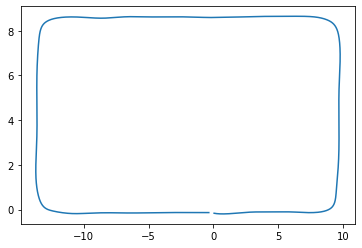

In [10]:
plt.plot(x_list_new, y_list_new)


## Using Casadi for cubic spline

In [11]:
cs_x = ca.interpolant('cs_x','bspline',[l_list[::40]],x_list[::40])
cs_y = ca.interpolant('cs_y','bspline',[l_list[::40]],y_list[::40])


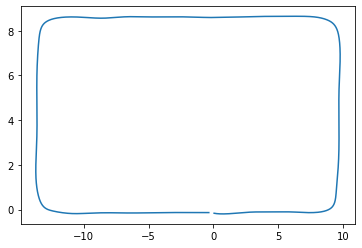

In [12]:
plt.plot(cs_x(l_list[:L]).full(), cs_y(l_list[:L]).full())

In [13]:
x = ca.MX.sym('x')
Phi = ca.Function('Phi', [x], [ca.arctan(ca.jacobian(cs_y(x),x)/ca.jacobian(cs_x(x),x))])
X = ca.MX.sym('X'); Y = ca.MX.sym('Y'); th = ca.MX.sym('th')
ec = ca.sin(Phi(th))*(X - cs_x(th)) - ca.cos(Phi(th))*(Y - cs_y(th))


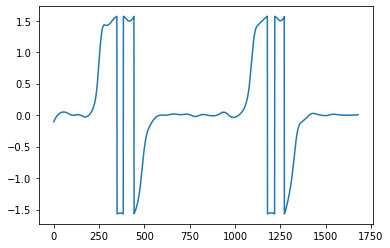

In [14]:
plt.plot(Phi(l_list[:1680]).full())

## Contouring class

In [20]:
class contour_car:
    T = 0.1; H = 10;
    lf = 0.16; lr = 0.17
    
    v_min = 0; v_max = 2
    delta_min = -0.4; delta_max = 0.4
    nu_min = 0; nu_max = 10
    
    def __init__(self, x0):
        self.st = x0
        self.arc = 0
        self.input = np.array([0, 0])
        self.ramp_v_min = -5*self.T; self.ramp_v_max = 5*self.T; 
        self.ramp_delta_min = -np.pi*self.T; self.ramp_delta_max = np.pi*self.T
        
    def set_weight(self, qc, ql, Ru, Rv, gamma):
        self.qc = qc
        self.ql = ql
        self.Ru = Ru
        self.Rv = Rv
        self.gamma = gamma
        
    def track_constraints(self, A, b):
        self.A = A
        self.b = b
        
    def cubic_spline(self, l_list, x_list, y_list, step = 40):
        self.L = int(len(x_list)/step)*step
        self.cs_x = ca.interpolant('cs_x','bspline',[l_list[::step]],x_list[::step])
        self.cs_y = ca.interpolant('cs_y','bspline',[l_list[::step]],y_list[::step])
        th = ca.MX.sym('th')
        # Tangent angle
        self.Phi = ca.Function('Phi', [th], [ca.arctan(ca.jacobian(self.cs_y(th),th)/ca.jacobian(self.cs_x(th),th))])

    def formulateMPC(self):
        X = ca.MX.sym('X'); Y = ca.MX.sym('Y'); th = ca.MX.sym('th')
        self.e_c = ca.Function('e_c', [X, Y, th], \
                [ca.sin(self.Phi(th))*(X - self.cs_x(th)) - ca.cos(self.Phi(th))*(Y - self.cs_y(th))])
        self.e_l = ca.Function('e_l', [X, Y, th], \
                [-ca.cos(self.Phi(th))*(X - self.cs_x(th)) - ca.sin(self.Phi(th))*(Y - self.cs_y(th))]) 
        
        x = ca.SX.sym('x'); y = ca.SX.sym('y'); phi = ca.SX.sym('phi') 
        v = ca.SX.sym('v'); delta = ca.SX.sym('delta') 
        state = np.array([x, y, phi])
        control = np.array([v, delta])
        beta = np.arctan(self.lr/(self.lf+self.lr)*ca.tan(delta))
        rhs = np.array([v*ca.cos(phi+beta), v*ca.sin(phi+beta), v*ca.sin(beta)/self.lr])*self.T + state
        self.f_dyn = ca.Function('f_dyn', [state,control], [rhs])
        
        self.mpc_opti = ca.casadi.Opti()
        self.U = self.mpc_opti.variable(2, self.H)
        self.X = self.mpc_opti.variable(3, self.H+1)
        self.TH = self.mpc_opti.variable(self.H+1)
        self.NU = self.mpc_opti.variable(self.H)
        self.P_1 = self.mpc_opti.parameter(3)
        self.P_2 = self.mpc_opti.parameter(2)
#         self.P_Ar = self.mpc_opti.parameter(self.H, 2)
#         self.P_br = self.mpc_opti.parameter(self.H)
        
        J = 0
        for k in range(self.H+1):
            J += self.qc*self.e_c(self.X[0,k], self.X[1,k], self.TH[k])**2 \
                + self.ql*self.e_l(self.X[0,k], self.X[1,k], self.TH[k])**2
        for k in range(self.H-1):
            J += self.Ru[0]*(self.U[0,k+1]-self.U[0,k])**2 + self.Ru[1]*(self.U[1,k+1]-self.U[1,k])**2 \
                + self.Rv*(self.NU[k+1]-self.NU[k])**2
            
        J += -self.gamma*self.TH[-1]
        self.mpc_opti.minimize(J) 
        
        for k in range(self.H):
            self.mpc_opti.subject_to(self.X[:,k+1] == self.f_dyn(self.X[:,k], self.U[:,k]))
            self.mpc_opti.subject_to(self.TH[k+1] == self.TH[k] + self.T*self.NU[k])
            
        self.mpc_opti.subject_to(0 <= self.TH)
        self.mpc_opti.subject_to(self.TH <= self.L)
        
        self.mpc_opti.subject_to(self.nu_min <= self.NU)
        self.mpc_opti.subject_to(self.NU <= self.nu_max)
        
        self.mpc_opti.subject_to(self.v_min <= self.U[0,:])
        self.mpc_opti.subject_to(self.U[0,:] <= self.v_max)
        self.mpc_opti.subject_to(self.delta_min <= self.U[1,:])
        self.mpc_opti.subject_to(self.U[1,:] <= self.delta_max)
        
        self.mpc_opti.subject_to(self.ramp_v_min <= self.U[0,0] - self.P_2[0])
        self.mpc_opti.subject_to(self.U[0,0] - self.P_2[0] <= self.ramp_v_max)
        self.mpc_opti.subject_to(self.ramp_delta_min <= self.U[1,0] - self.P_2[1])
        self.mpc_opti.subject_to(self.U[1,0] - self.P_2[1] <= self.ramp_delta_max)
        
        self.mpc_opti.subject_to(self.ramp_v_min <= self.U[0,1:] - self.U[0,0:-1])
        self.mpc_opti.subject_to(self.U[0,1:] - self.U[0,0:-1] <= self.ramp_v_max)
        self.mpc_opti.subject_to(self.ramp_delta_min <= self.U[1,1:] - self.U[1,0:-1])
        self.mpc_opti.subject_to(self.U[1,1:] - self.U[1,0:-1] <= self.ramp_delta_max)

        self.mpc_opti.subject_to(self.X[:,0] == self.P_1[0:3])
        
        p_opts = {'verbose_init': False}
        s_opts = {'tol': 0.01, 'print_level': 0, 'max_iter': 100}
        self.mpc_opti.solver('ipopt', p_opts, s_opts)

        # Warm up
        self.mpc_opti.set_value(self.P_1, self.st)
        self.mpc_opti.set_value(self.P_2, self.input)
#         self.mpc_opti.set_value(self.P_Ar, self.Ar[0:car.H, :])
#         self.mpc_opti.set_value(self.P_br, self.br[0:car.H])
        
        sol = self.mpc_opti.solve()
        self.mpc_opti.set_initial(self.U, sol.value(self.U))
        self.mpc_opti.set_initial(self.X, sol.value(self.X))
        self.mpc_opti.set_initial(self.NU, sol.value(self.NU))
        self.mpc_opti.set_initial(self.TH, sol.value(self.TH))

    def solveMPC(self):
        self.mpc_opti.set_value(self.P_1, self.st)
        self.mpc_opti.set_value(self.P_2, self.input)
#         self.mpc_opti.set_value(self.P_Ar, self.Ar[i:i+car.H, :])
#         self.mpc_opti.set_value(self.P_br, self.br[i:i+car.H])
        try:
            sol = self.mpc_opti.solve()
            
        except RuntimeError:
            print("An exception occurred")
            control = self.mpc_opti.debug.value(self.U)
            self.arc = self.mpc_opti.debug.value(self.TH)[0]

        else:
            control = sol.value(self.U)
            self.mpc_opti.set_initial(self.X, np.hstack((sol.value(self.X)[:,1:], sol.value(self.X)[:,-1:])))
            self.mpc_opti.set_initial(self.U, np.hstack((sol.value(self.U)[:,1:], sol.value(self.U)[:,-1:])))    
            self.mpc_opti.set_initial(self.TH, np.hstack((sol.value(self.TH)[1:], sol.value(self.TH)[-1:])))
            self.mpc_opti.set_initial(self.NU, np.hstack((sol.value(self.NU)[1:], sol.value(self.NU)[-1:]))) 
            self.arc = sol.value(self.TH)[0]
        print(self.arc)
        return control[:,0]
        
    def car_model(self, z, t, u):
        phi = z[2]
        v = u[0]; delta = u[1]

        beta = np.arctan(self.lr/(self.lf+self.lr)*np.tan(delta))
        dz = np.zeros(3)
        dz[0] = v*np.cos(phi+beta)
        dz[1] = v*np.sin(phi+beta)
        dz[2] = v/self.lr*np.sin(beta)
        return dz
        
    def run(self, u):
        tspan = np.linspace(0, self.T, 3)
        y = odeint(self.car_model, self.st, tspan, args=(u,)) 
        self.st = y[-1,] 
        self.input = u


In [34]:
car = contour_car(np.zeros((3)))
car.set_weight(2, 100, np.array([1, 1]), 1, 2)
# Ar = np.vstack([Ar_sel, Ar_sel[-1, :]*np.ones((car.H,2))])
# br = np.hstack([br_sel, br_sel[-1]*np.ones(car.H)])
# car.load_data(Ar, br)
car.cubic_spline(l_list, x_list, y_list, step = 40)
car.formulateMPC()


      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   1.00ms ( 76.92us) 965.00us ( 74.23us)        13
       nlp_g  |        0 (       0)        0 (       0)        13
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |   2.00ms (142.86us)   2.00ms (142.93us)        14
  nlp_hess_l  |   9.00ms (750.00us)   8.99ms (749.58us)        12
   nlp_jac_g  |   1.00ms ( 71.43us) 997.00us ( 71.21us)        14
       total  |  22.00ms ( 22.00ms)  22.00ms ( 22.00ms)         1


In [35]:
X_hist = car.st.reshape(-1,1)

In [36]:
i = 0
while car.arc < car.L - 10:
    u = car.solveMPC()
    car.run(u)
    X_hist = np.hstack((X_hist, car.st.reshape(-1,1)))
    i += 1

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)         9
       nlp_g  |   1.00ms (111.11us) 999.00us (111.00us)         9
    nlp_grad  |   1.00ms (  1.00ms)   1.00ms (  1.00ms)         1
  nlp_grad_f  |   2.00ms (200.00us)   1.96ms (196.30us)        10
  nlp_hess_l  |   7.00ms (875.00us)   7.04ms (879.62us)         8
   nlp_jac_g  |        0 (       0)        0 (       0)        10
       total  |  17.00ms ( 17.00ms)  17.00ms ( 17.00ms)         1
2.7614111305852407
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)        10
       nlp_g  |        0 (       0)        0 (       0)        10
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |   3.00ms (272.73us)   3.02ms (274.36us)        11
  nlp_hess_l  |   8.00ms (888.89us)   8.04ms (893.44us)         9
   nlp_jac_g  |        0 (       0)        0 (       0)  

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)         9
       nlp_g  |        0 (       0)        0 (       0)         9
    nlp_grad  |   1.00ms (  1.00ms) 883.00us (883.00us)         1
  nlp_grad_f  |   1.00ms (100.00us)   1.03ms (103.40us)        10
  nlp_hess_l  |   9.00ms (  1.12ms)   9.01ms (  1.13ms)         8
   nlp_jac_g  |        0 (       0)        0 (       0)        10
       total  |  14.00ms ( 14.00ms)  14.03ms ( 14.03ms)         1
106.749077570954
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)         9
       nlp_g  |        0 (       0)        0 (       0)         9
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |   4.00ms (400.00us)   4.00ms (400.00us)        10
  nlp_hess_l  |   4.00ms (500.00us)   4.00ms (499.62us)         8
   nlp_jac_g  |        0 (       0)        0 (       0)    

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)         9
       nlp_g  |        0 (       0)        0 (       0)         9
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |   4.00ms (400.00us)   4.03ms (403.30us)        10
  nlp_hess_l  |   4.00ms (500.00us)   3.96ms (495.37us)         8
   nlp_jac_g  |   1.00ms (100.00us)   1.03ms (102.60us)        10
       total  |  14.00ms ( 14.00ms)  14.03ms ( 14.03ms)         1
165.3860660923878
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)         9
       nlp_g  |        0 (       0)        0 (       0)         9
    nlp_grad  |   1.00ms (  1.00ms)   1.00ms (  1.00ms)         1
  nlp_grad_f  |   1.00ms (100.00us)   1.03ms (103.30us)        10
  nlp_hess_l  |   7.00ms (875.00us)   6.98ms (873.00us)         8
   nlp_jac_g  |        0 (       0)        0 (       0)   

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)         9
       nlp_g  |        0 (       0)        0 (       0)         9
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |   4.00ms (400.00us)   4.03ms (402.80us)        10
  nlp_hess_l  |   4.00ms (500.00us)   3.97ms (496.37us)         8
   nlp_jac_g  |        0 (       0)        0 (       0)        10
       total  |  13.00ms ( 13.00ms)  13.04ms ( 13.04ms)         1
227.735248079264
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)         9
       nlp_g  |        0 (       0)        0 (       0)         9
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |   1.00ms (100.00us)   1.03ms (103.30us)        10
  nlp_hess_l  |   7.00ms (875.00us)   7.00ms (875.00us)         8
   nlp_jac_g  |        0 (       0)        0 (       0)    

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0) 140.00us ( 15.56us)         9
       nlp_g  |        0 (       0)        0 (       0)         9
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |        0 (       0)        0 (       0)        10
  nlp_hess_l  |   7.00ms (875.00us)   7.48ms (935.12us)         8
   nlp_jac_g  |        0 (       0)        0 (       0)        10
       total  |  14.00ms ( 14.00ms)  14.68ms ( 14.68ms)         1
365.0901713589033
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)         9
       nlp_g  |        0 (       0)        0 (       0)         9
    nlp_grad  |   1.00ms (  1.00ms) 996.00us (996.00us)         1
  nlp_grad_f  |        0 (       0)        0 (       0)        10
  nlp_hess_l  |   5.00ms (625.00us)   4.15ms (519.25us)         8
   nlp_jac_g  |   2.00ms (200.00us)   2.00ms (200.50us)   

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)        10
       nlp_g  |        0 (       0)        0 (       0)        10
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |   4.00ms (363.64us)   4.04ms (366.91us)        11
  nlp_hess_l  |   4.00ms (444.44us)   4.13ms (458.89us)         9
   nlp_jac_g  |        0 (       0)        0 (       0)        11
       total  |  13.00ms ( 13.00ms)  13.17ms ( 13.17ms)         1
499.3202276472023
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)         9
       nlp_g  |        0 (       0)        0 (       0)         9
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |   1.00ms (100.00us)   1.03ms (102.90us)        10
  nlp_hess_l  |   7.00ms (875.00us)   6.99ms (874.25us)         8
   nlp_jac_g  |        0 (       0)        0 (       0)   

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   3.00ms (333.33us)   2.91ms (322.89us)         9
       nlp_g  |        0 (       0)        0 (       0)         9
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |   1.00ms (100.00us) 967.00us ( 96.70us)        10
  nlp_hess_l  |   4.00ms (500.00us)   4.01ms (501.25us)         8
   nlp_jac_g  |        0 (       0)        0 (       0)        10
       total  |  13.00ms ( 13.00ms)  13.05ms ( 13.05ms)         1
584.4419023646967
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)         9
       nlp_g  |        0 (       0)        0 (       0)         9
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |   4.00ms (400.00us)   4.00ms (399.80us)        10
  nlp_hess_l  |   4.00ms (500.00us)   4.03ms (503.87us)         8
   nlp_jac_g  |        0 (       0)        0 (       0)   

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)         9
       nlp_g  |        0 (       0)        0 (       0)         9
    nlp_grad  |   1.00ms (  1.00ms)   1.00ms (  1.00ms)         1
  nlp_grad_f  |        0 (       0)        0 (       0)        10
  nlp_hess_l  |   6.00ms (750.00us)   6.17ms (771.87us)         8
   nlp_jac_g  |        0 (       0)        0 (       0)        10
       total  |  14.00ms ( 14.00ms)  14.71ms ( 14.71ms)         1
699.219165065572
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)         9
       nlp_g  |        0 (       0)        0 (       0)         9
    nlp_grad  |   1.00ms (  1.00ms)   1.00ms (  1.00ms)         1
  nlp_grad_f  |        0 (       0)        0 (       0)        10
  nlp_hess_l  |   9.00ms (  1.12ms)   8.65ms (  1.08ms)         8
   nlp_jac_g  |        0 (       0)        0 (       0)    

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)         9
       nlp_g  |        0 (       0)        0 (       0)         9
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |        0 (       0)   1.03ms (102.90us)        10
  nlp_hess_l  |   7.00ms (875.00us)   7.00ms (874.50us)         8
   nlp_jac_g  |   2.00ms (200.00us)   2.00ms (200.00us)        10
       total  |  14.00ms ( 14.00ms)  14.03ms ( 14.03ms)         1
807.2685618907531
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   1.00ms (111.11us)   1.00ms (111.44us)         9
       nlp_g  |        0 (       0)        0 (       0)         9
    nlp_grad  |   1.00ms (  1.00ms) 969.00us (969.00us)         1
  nlp_grad_f  |        0 (       0)        0 (       0)        10
  nlp_hess_l  |   6.00ms (750.00us)   5.98ms (748.00us)         8
   nlp_jac_g  |        0 (       0)        0 (       0)   

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   2.00ms (222.22us)   1.94ms (215.56us)         9
       nlp_g  |        0 (       0)        0 (       0)         9
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |        0 (       0)        0 (       0)        10
  nlp_hess_l  |   5.00ms (625.00us)   4.84ms (605.00us)         8
   nlp_jac_g  |        0 (       0)        0 (       0)        10
       total  |  14.00ms ( 14.00ms)  13.66ms ( 13.66ms)         1
866.5356114652902
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)         9
       nlp_g  |        0 (       0)        0 (       0)         9
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |   1.00ms (100.00us)   1.00ms (100.00us)        10
  nlp_hess_l  |   7.00ms (875.00us)   7.64ms (955.12us)         8
   nlp_jac_g  |        0 (       0)        0 (       0)   

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)         9
       nlp_g  |        0 (       0)        0 (       0)         9
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |   1.00ms (100.00us)   1.00ms (100.00us)        10
  nlp_hess_l  |   4.00ms (500.00us)   4.20ms (525.12us)         8
   nlp_jac_g  |   1.00ms (100.00us)   1.00ms (100.00us)        10
       total  |  14.00ms ( 14.00ms)  13.74ms ( 13.74ms)         1
925.9744804739462
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)         9
       nlp_g  |        0 (       0)        0 (       0)         9
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |   1.00ms (100.00us)   1.03ms (103.20us)        10
  nlp_hess_l  |   8.00ms (  1.00ms)   8.49ms (  1.06ms)         8
   nlp_jac_g  |        0 (       0)        0 (       0)   

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   1.00ms (111.11us) 968.00us (107.56us)         9
       nlp_g  |        0 (       0)        0 (       0)         9
    nlp_grad  |   1.00ms (  1.00ms)   1.00ms (  1.00ms)         1
  nlp_grad_f  |   1.00ms (100.00us)   1.00ms (100.00us)        10
  nlp_hess_l  |   5.00ms (625.00us)   5.01ms (626.62us)         8
   nlp_jac_g  |        0 (       0)        0 (       0)        10
       total  |  14.00ms ( 14.00ms)  14.03ms ( 14.03ms)         1
1034.8160670931031
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)         9
       nlp_g  |        0 (       0)        0 (       0)         9
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |   3.00ms (300.00us)   3.00ms (300.40us)        10
  nlp_hess_l  |   4.00ms (500.00us)   4.03ms (503.75us)         8
   nlp_jac_g  |   1.00ms (100.00us)   1.00ms (100.20us)  

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)         8
       nlp_g  |        0 (       0) 176.00us ( 22.00us)         8
    nlp_grad  |   1.00ms (  1.00ms)   1.00ms (  1.00ms)         1
  nlp_grad_f  |        0 (       0)        0 (       0)         9
  nlp_hess_l  |   8.00ms (  1.14ms)   7.51ms (  1.07ms)         7
   nlp_jac_g  |        0 (       0)        0 (       0)         9
       total  |  13.00ms ( 13.00ms)  12.71ms ( 12.71ms)         1
1124.9317847284733
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)         9
       nlp_g  |        0 (       0)        0 (       0)         9
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |        0 (       0)        0 (       0)        10
  nlp_hess_l  |   6.00ms (750.00us)   6.07ms (758.62us)         8
   nlp_jac_g  |        0 (       0)        0 (       0)  

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   1.00ms (111.11us)   1.00ms (111.11us)         9
       nlp_g  |        0 (       0)        0 (       0)         9
    nlp_grad  |   1.00ms (  1.00ms)   1.00ms (  1.00ms)         1
  nlp_grad_f  |        0 (       0)        0 (       0)        10
  nlp_hess_l  |   8.00ms (  1.00ms)   7.64ms (955.12us)         8
   nlp_jac_g  |        0 (       0)        0 (       0)        10
       total  |  17.00ms ( 17.00ms)  16.68ms ( 16.68ms)         1
1230.7603986729014
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)         9
       nlp_g  |        0 (       0)        0 (       0)         9
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |   3.00ms (300.00us)   3.00ms (299.90us)        10
  nlp_hess_l  |   6.00ms (750.00us)   6.07ms (758.62us)         8
   nlp_jac_g  |   1.00ms (100.00us)   1.00ms (100.10us)  

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)         9
       nlp_g  |        0 (       0)        0 (       0)         9
    nlp_grad  |   1.00ms (  1.00ms)   1.00ms (  1.00ms)         1
  nlp_grad_f  |   1.00ms (100.00us)   1.00ms (100.00us)        10
  nlp_hess_l  |   6.00ms (750.00us)   5.98ms (748.12us)         8
   nlp_jac_g  |        0 (       0)        0 (       0)        10
       total  |  15.00ms ( 15.00ms)  15.00ms ( 15.00ms)         1
1288.339377505897
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   2.00ms (222.22us)   2.00ms (221.89us)         9
       nlp_g  |        0 (       0)        0 (       0)         9
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |   3.00ms (300.00us)   2.97ms (296.60us)        10
  nlp_hess_l  |   6.00ms (750.00us)   5.97ms (746.12us)         8
   nlp_jac_g  |        0 (       0)        0 (       0)   

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   1.00ms (111.11us)   1.00ms (111.11us)         9
       nlp_g  |        0 (       0)        0 (       0)         9
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |   3.00ms (300.00us)   2.97ms (296.80us)        10
  nlp_hess_l  |   5.00ms (625.00us)   5.03ms (628.50us)         8
   nlp_jac_g  |        0 (       0)        0 (       0)        10
       total  |  24.00ms ( 24.00ms)  24.72ms ( 24.72ms)         1
1416.7629562003815
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)         9
       nlp_g  |        0 (       0)        0 (       0)         9
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |        0 (       0)        0 (       0)        10
  nlp_hess_l  |   6.00ms (750.00us)   6.12ms (765.25us)         8
   nlp_jac_g  |   1.00ms (100.00us)   1.00ms (100.10us)  

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)         9
       nlp_g  |        0 (       0)        0 (       0)         9
    nlp_grad  |   1.00ms (  1.00ms)   1.08ms (  1.08ms)         1
  nlp_grad_f  |   1.00ms (100.00us)   1.00ms (100.00us)        10
  nlp_hess_l  |   6.00ms (750.00us)   6.00ms (750.25us)         8
   nlp_jac_g  |        0 (       0)        0 (       0)        10
       total  |  14.00ms ( 14.00ms)  14.08ms ( 14.08ms)         1
1495.3919142742034
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)         9
       nlp_g  |        0 (       0)        0 (       0)         9
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |        0 (       0)        0 (       0)        10
  nlp_hess_l  |   7.00ms (875.00us)   7.00ms (874.50us)         8
   nlp_jac_g  |   1.00ms (100.00us)   1.00ms (100.00us)  

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   1.00ms (111.11us)   1.00ms (111.11us)         9
       nlp_g  |        0 (       0)        0 (       0)         9
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |   1.00ms (100.00us)   1.00ms (100.00us)        10
  nlp_hess_l  |   8.00ms (  1.00ms)   8.06ms (  1.01ms)         8
   nlp_jac_g  |        0 (       0)        0 (       0)        10
       total  |  16.00ms ( 16.00ms)  16.06ms ( 16.06ms)         1
1599.726951263523
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)         9
       nlp_g  |        0 (       0)        0 (       0)         9
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |        0 (       0)        0 (       0)        10
  nlp_hess_l  |   8.00ms (  1.00ms)   7.68ms (959.50us)         8
   nlp_jac_g  |   1.00ms (100.00us)   1.00ms (100.00us)   

CasADi -  WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi -  WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi -  WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


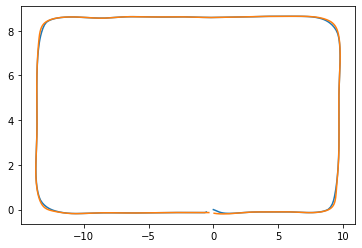

In [37]:
plt.plot(X_hist[0,:], X_hist[1,:])
plt.plot(car.cs_x(l_list[:L]), car.cs_y(l_list[:L]))

In [38]:
i

386